## Simple Neural network to recognize hand written Images

This is a simple neural network constructed in pytorch to train on MINST Hand written digits data set to recognize any image with a hand written number

### Import necessary utilities

The project is done in pytorch using Convolutional Neural Networks (CNNs)

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

import os

### Config

Lets set some global variables such as seed value.

In [2]:
seed = 1
train_batch_size = 32
test_batch_size = 32

num_epochs = 10
num_classes = 10
learning_rate = 0.001

valid_size = 0.1

torch.manual_seed(seed)
np.random.seed(seed)

### Data

The data can be downloaded from here:

http://yann.lecun.com/exdb/mnist/

Four files are available on this site:

- train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
- train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
- t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
- t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)


the data is downloaded in data directory

Lets load the MINST dataset. The following code takes care of downloading, wrapping around the DataLoader and normalizing the data:

In [3]:
# Normalization for MNIST dataset.
dataset_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

In [4]:
train_dataset = datasets.MNIST('data/', train=True,  download=True, transform=dataset_transform)
valid_dataset = datasets.MNIST('data/', train=True,  download=True, transform=dataset_transform)
test_dataset  = datasets.MNIST('data/', train=False, download=True, transform=dataset_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, sampler=train_sampler, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, sampler=valid_sampler, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

Lets examine a sample image using matplotlib ploting library

we would get one batch from the loader of 32 images and plot in 8 x 4 grid

each image is 28 x 28 x 1 meaning single channel square image with length and higet = 28 pixels

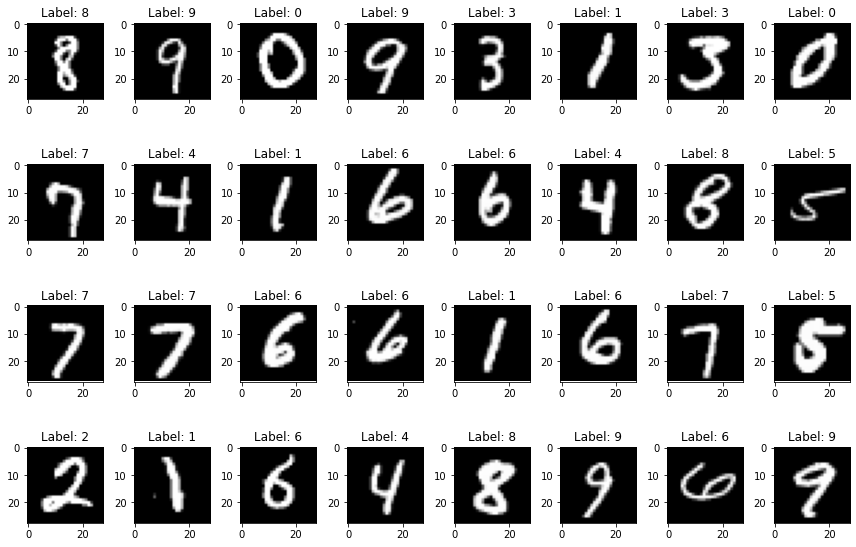

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

train_iterator = iter(train_loader)
images, labels = train_iterator.next() # Batch of 64

num_row = 4
num_col = 8

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(train_batch_size):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i][0], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    #save_image(images[i], "img"+str(i)+".png")
plt.tight_layout()
plt.show()

## Neural Network

We define our neural network with with 2 sequence of 2d convolutional layers followed by RELU activationa and max pooling. At the end will ba a fully connected layer followed by softmax. 

<img src="images/network.jpg" style="width:800px;height:300px;">

To calculate the dimensions of our neurons, we would use following util functions

In [7]:
def conv_output_volume(W, F, S, P):
    
    """
    Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    """
    return int((W - F + 2*P) / S) + 1

def maxpool_output_volume(W, F, S):
    
    """
    Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    """
    return int(np.ceil((W - F + 1) / S))

In [8]:
# conv 1 output

input_size   = 28
filter_size  = 5
stride_size  = 1
padding_size = 0

conv_out_1 = conv_output_volume(input_size,filter_size,stride_size,padding_size)
conv_out_1

24

In [9]:
# pool 1 putput

input_size   = conv_out_1
filter_size  = 2
stride_size  = 2
padding_size = 0

pool_out_1 = maxpool_output_volume(input_size,filter_size,stride_size)
pool_out_1

12

In [10]:
# conv 1 output

input_size   = pool_out_1
filter_size  = 3
stride_size  = 1
padding_size = 0

conv_out_2 = conv_output_volume(input_size,filter_size,stride_size,padding_size)
conv_out_2

10

In [11]:
# pool 1 putput

input_size   = conv_out_2
filter_size  = 2
stride_size  = 2
padding_size = 0

pool_out_2 = maxpool_output_volume(input_size,filter_size,stride_size)
pool_out_2

5

Lets define are NN Class 

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        
        #fully connected layer
        self.fc = nn.Linear(5*5*32, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = x.reshape(x.size(0), -1)
        
        x = self.fc(x)
        
        return x

In [13]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
device = "cpu"

num_classes = 10

model = CNN(num_classes).to(device)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train the model
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    # Training loss in this epoc
    train_loss = 0
    
    # Testing loss in this epoc
    valid_loss = 0
    
    # accuracy this epoc
    accuracy = 0
    
    # Set in training mode
    model.train()
    
    # Train all images in batches
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    total = 0
    correct = 0
    with torch.no_grad():
      
        # Set model in evaluation mode
        model.eval()
      
        # Validation pass
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
        
            valid_loss += criterion(outputs, labels)
        
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy += (100 * correct / total)
    
    model.train()
    
    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(valid_loss/len(valid_loader))
    
    print (f'Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}, Validation Loss: {valid_loss/len(valid_loader)}, Accuracy: {accuracy} ')

C:\Users\maria\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1, Training Loss: 0.1634753205149252, Validation Loss: 0.11623192578554153, Accuracy: 97.01666666666667 
Epoch 2, Training Loss: 0.10315392338280095, Validation Loss: 0.13734214007854462, Accuracy: 96.23333333333333 
Epoch 3, Training Loss: 0.09534903462431796, Validation Loss: 0.130242720246315, Accuracy: 96.86666666666666 
Epoch 4, Training Loss: 0.09952499597518098, Validation Loss: 0.13484908640384674, Accuracy: 96.95 
Epoch 5, Training Loss: 0.10101241217653814, Validation Loss: 0.0918988287448883, Accuracy: 97.66666666666667 
Epoch 6, Training Loss: 0.0926692469791659, Validation Loss: 0.10469111055135727, Accuracy: 97.28333333333333 
Epoch 7, Training Loss: 0.09506685922471372, Validation Loss: 0.12856677174568176, Accuracy: 96.43333333333334 
Epoch 8, Training Loss: 0.09547453763801779, Validation Loss: 0.1312548667192459, Accuracy: 96.9 
Epoch 9, Training Loss: 0.09482863805263654, Validation Loss: 0.118851438164711, Accuracy: 96.58333333333333 
Epoch 10, Training Loss: 

In [16]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy of the model: {(100 * correct / total)}')

Test Accuracy of the model: 97.64


tensor([[-20.7470, -21.3344, -11.5075,  -6.9466, -21.2748,  -5.7624, -13.4494,
         -36.0074,   6.7323, -40.3142]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([6.7323]),
indices=tensor([8]))
8
Prediction  tensor(8)


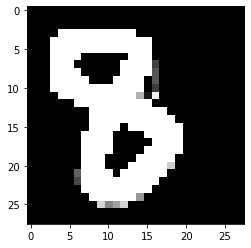

In [17]:
# input an image and test with it

from PIL import Image
import torchvision.transforms as transforms

image_transform = transforms.Compose([
                        transforms.Resize(28),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
    
image_name = 'test1.jpg'

image = images[0]
image = Image.open('images/' + image_name)

# Grascale
image = image.convert('L')

image = image_transform(image)


prediction = model(image.unsqueeze(0))
print(prediction)
print(torch.max(prediction.data, 1))
_, prediction = torch.max(prediction.data, 1)

print(int(prediction[0]))
print("Prediction ",prediction[0])

# plot the sample
fig = plt.figure
plt.imshow(image[0], cmap='gray')
plt.show()